In [72]:
from dotenv import load_dotenv
import os
from pathlib import Path
import pandas as pd
from datetime import datetime, timedelta
from tqdm.auto import tqdm
import pickle
import seaborn as sns
from matplotlib import pyplot as plt


load_dotenv()
data_fol = Path(os.getenv("DATA_FOL"))
v1 = data_fol / 'v1'
tn_v1 = data_fol / 'tn_v1'

def load_pickle(file):
    return pickle.load(open(file, 'rb'))

temp = load_pickle(data_fol/'weather.pkl')
rainfall = load_pickle(data_fol/'rainfall.pkl')



In [67]:
def apply_temp_rainfall(row):
    
    date = row['date'].date()
    cur_temp = temp.get(date, (None, None))

    row['tmin'] = cur_temp[0]
    row['tmax'] = cur_temp[1]
    row['rainfall'] = rainfall.get(str(date), None)

    return row


def open_file(file_name):

    df = pd.read_feather(file_name)
    df = df.apply(apply_temp_rainfall, axis=1)
    df = df.dropna()
    df = df.set_index('date')
    df = df.drop(['min', 'max'], axis=1)
    df = df.rename(columns={'modal': 'price'})

    # time series features
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear

    return df

In [86]:
df = open_file(tn_v1/'Groundnut.feather')
df

,price,tmin,tmax,rainfall,month,year,dayofyear
date,,,,,,,
2015-01-05,4082.89,24.0,32.3,0.0000,1,2015,5
2015-01-12,4412.68,22.6,30.2,0.0000,1,2015,12
2015-01-19,4136.27,19.6,32.2,0.0000,1,2015,19
2015-01-26,4251.62,21.8,31.8,0.0000,1,2015,26
2015-02-02,4133.55,20.6,32.1,0.0000,2,2015,33
...,...,...,...,...,...,...,...
2023-08-21,9167.27,28.0,38.0,5.3474,8,2023,233
2023-08-28,8642.67,26.0,38.0,53.3432,8,2023,240
2023-09-04,8876.73,24.6,36.2,114.9363,9,2023,247


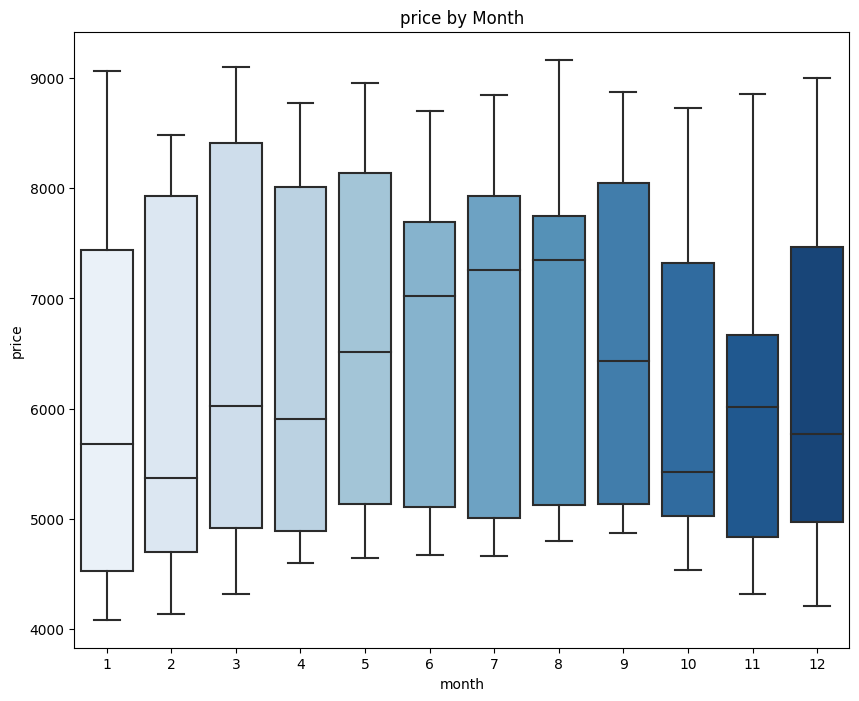

In [96]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='price', palette='Blues')
ax.set_title('price by Month')
plt.show()

<AxesSubplot:xlabel='date'>

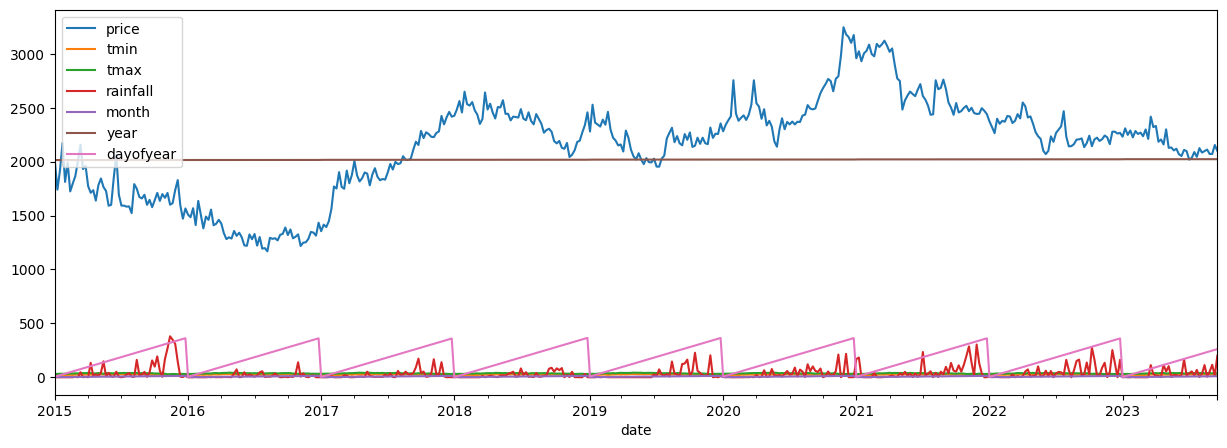

In [92]:
Coconut = open_file(tn_v1/'Coconut.feather')
Coconut.plot(figsize=(15, 5))

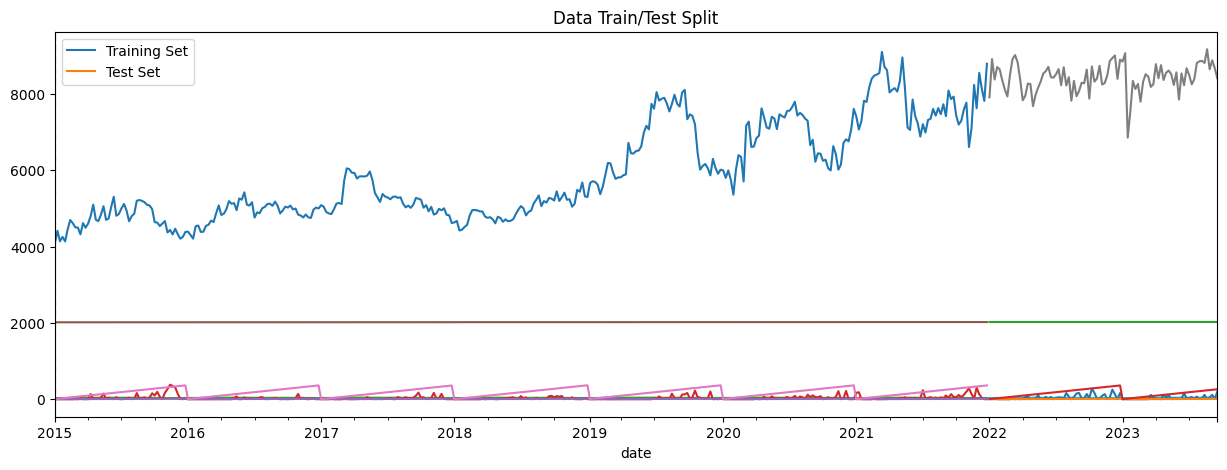

In [94]:
split_date = datetime(year=2022, month=1, day=1)

train = df.loc[df.index < split_date]
test = df.loc[df.index >= split_date]

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	
	n_vars = 1 if type(data) is list else data.shape[1]
	
	dff = pd.DataFrame(data)
	
	cols, names = list(), list()
	
    # input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(dff.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
		

	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(dff.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	
    # put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names

 
	if dropnan:
		agg.dropna(inplace=True)
	
	return agg

In [ ]:
FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'price'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]